In [2]:
# Install the required modules
!pip install transformers
!pip install pandas
!pip install numpy
!pip install tqdm
!pip install sklearn

from google.colab import drive
drive.mount('/content/gdrive')

# !nvidia-smi

     |████████████████████████████████| 368kB 45.7MB/s 
     |████████████████████████████████| 860kB 54.3MB/s 
     |████████████████████████████████| 1.0MB 52.2MB/s 
     |████████████████████████████████| 645kB 48.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=a5ac1c1df4d38fff65e019c6a69be5c3f00e08c5aaa4f4c97a32f23b2abbcd9e
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your

In [3]:
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import *

In [0]:
# Embeddings can be derived from the last 1 or 4 layers, to reduce the computational cost, we used only the last layer.

class Embeddings:
    LAST_LAYER = 1
    LAST_4_LAYERS = 2
    def __init__(self):
        self._tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self._bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self._bert_model.eval()

    def tokenize(self, sentence):
        """

        :param sentence: input sentence ['str']
        :return: tokenized sentence based on word piece model ['List']
        """
        marked_sentence = "[CLS] " + sentence + " [SEP]"
        tokenized_text = self._tokenizer.tokenize(marked_sentence)
        return tokenized_text

    def get_bert_embeddings(self, sentence):
        """

        :param sentence: input sentence ['str']
        :return: BERT pre-trained hidden states (list of torch tensors) ['List']
        """
        # Predict hidden states features for each layer

        tokenized_text = self.tokenize(sentence)
        indexed_tokens = self._tokenizer.convert_tokens_to_ids(tokenized_text)

        segments_ids = [1] * len(tokenized_text)

        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        with torch.no_grad():
            encoded_layers = self._bert_model(tokens_tensor, segments_tensors)

        return encoded_layers[-1][0:12]

    def sentence2vec(self, sentence, layers):
        """

        :param sentence: input sentence ['str']
        :param layers: parameter to decide how word embeddings are obtained ['str]
            1. 'last' : last hidden state used to obtain word embeddings for sentence tokens
            2. 'last_4' : last 4 hidden states used to obtain word embeddings for sentence tokens

        :return: sentence vector [List]
        """
        encoded_layers = self.get_bert_embeddings(sentence)
        
        if layers == 1:
            # using the last layer embeddings
            token_embeddings = encoded_layers[-1]
            # summing the last layer vectors for each token
            sentence_embedding = torch.mean(token_embeddings, 1)
            return sentence_embedding.view(-1).tolist()

        elif layers == 2:
            token_embeddings = []
            tokenized_text = self.tokenize(sentence)

            batch_i = 0
            # For each token in the sentence...
            for token_i in range(len(tokenized_text)):

                # Holds 12 layers of hidden states for each token
                hidden_layers = []

                # For each of the 12 layers...
                for layer_i in range(len(encoded_layers)):
                    # Lookup the vector for `token_i` in `layer_i`
                    vec = encoded_layers[layer_i][batch_i][token_i]

                    hidden_layers.append(list(vec.numpy()))

                token_embeddings.append(hidden_layers)

            # using the last 4 layer embeddings
            token_vecs_sum = []

            # For each token in the sentence...
            for token in token_embeddings:
                # Sum the vectors from the last four layers.
                sum_vec = np.sum(token[-4:], axis=0)

                # Use `sum_vec` to represent `token`.
                token_vecs_sum.append(list(sum_vec))

            # summing the last layer vectors for each token
            sentence_embedding = np.mean(token_vecs_sum, axis=0)
            return sentence_embedding.ravel().tolist()

In [0]:
# Dataset: 3000 chunks * 3 authors, without masking

# url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/Datasets/raw_text_3000.csv'
# df = pd.read_csv(url)

# X = df.text.astype('str')
# y = df.author.astype('category')

# # lbl_enc = preprocessing.LabelEncoder()
# # y = lbl_enc.fit_transform(y.values)

# y = np.asarray(y)
# onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
# encoded = y.reshape(len(y), 1)
# y = onehot_encoder.fit_transform(encoded)

In [0]:
# Dataset: 3000 chunks * 3 authors, with masking

url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/Datasets/masked_text_3000.csv'
df = pd.read_csv(url)

X = df.text.astype('str')
y = df.author.astype('category')

# lbl_enc = preprocessing.LabelEncoder()
# y = lbl_enc.fit_transform(y.values)

y = np.asarray(y)
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
encoded = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(encoded)

In [0]:
# model = Embeddings()

# X_text = []
# for sentence in tqdm(X):
#     X_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))

In [0]:
# For Test Time

url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/outputs/masked_results.csv'
dft = pd.read_csv(url).set_index('Unnamed: 0')

X_old = dft.old.astype('str')
X_new = dft.new.astype('str')

model = Embeddings()

X_old_text, X_new_text = [], []
for sentence in tqdm(X_old):
    X_old_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))
for sentence in tqdm(X_new):
    X_new_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))

100%|██████████| 55/55 [00:34<00:00,  1.57it/s]


In [0]:
# X_old = pd.DataFrame(X_old_text)
# X_old.to_csv('./gdrive/My Drive/DL/Style/X_old_Embedding.csv')

# X_new = pd.DataFrame(X_new_text)
# X_new.to_csv('./gdrive/My Drive/DL/Style/X_new_Embedding.csv')

In [0]:
# X_df = pd.DataFrame(X_text)
# X_df.to_csv('./gdrive/My Drive/DL/Style/DistilBert_Embedding_3000_2.csv')

In [0]:
# For old Rand examples

# url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/outputs/rand_examples.csv'
# df = pd.read_csv(url).set_index('Unnamed: 0')


# X1 = df['Rand-donor-text'].astype('str')
# X2 = df['Rand_117M_10000_Nabokov-All-3'].astype('str')
# X3 = df['Rand-output-ngram'].astype('str')

# model = Embeddings()

# X1_text, X2_text, X3_text = [], [], []
# for sentence in tqdm(X1):
#     X1_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))
# for sentence in tqdm(X2):
#     X2_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))
# for sentence in tqdm(X2):
#     X3_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))

100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


### Building A Atyle Alassifier on Top of DistilBert Embeddings

In [7]:
# For Baselines

url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/Datasets/masked_text_3000.csv'
df = pd.read_csv(url)

X = df.text.astype('str')
y = df.author.astype('category')

lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(y.values)

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2, shuffle=True)
xvalid, xtest, yvalid, ytest = train_test_split(xvalid, yvalid, test_size=0.5, random_state=1, shuffle=True)

print(xtrain.shape, xvalid.shape)

(7200,) (900,)


In [6]:
# X_df = pd.DataFrame(X_text)
# X_df.to_csv('./gdrive/My Drive/DL/Style/DistilBert_Embedding_3000.csv')

X_df = pd.read_csv('./gdrive/My Drive/DL/Style/DistilBert_Embedding_3000_2.csv').set_index('Unnamed: 0')

X_train, X_val, y_train, y_val = train_test_split(X_df, y, stratify=y, random_state=1, test_size=0.2, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=1, shuffle=True)

print(X_train.shape, X_val.shape)

(7200, 768) (900, 768)


In [0]:
# Feed-Forward Neural Nets
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        """The forward pass of the FFNN
        
        Args:
            x (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        c = self.fc1(x)
        x = self.bn1(c)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)
        c = torch.cat((x, c), 1)
        x = self.fc2(c)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)
        c = torch.cat((x, c), 1)
        x = self.fc3(c)
        x = self.bn3(x)
        x = F.relu(x)
        output = F.dropout(x, p=0.5)
     
        return output

batch_size = 32 # number of samples input at once
input_dim = 768
hidden_dim = 128
output_dim = 3

# Initialize model
model = FFNN(input_dim, hidden_dim, output_dim)
print(model)

X = torch.tensor(np.array(X_train))
# y_output = model(X)
# describe(y_output)

FFNN(
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (bn3): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Baselines


In [8]:
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from tqdm import tqdm
import xgboost as xgb
import sys
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import tensorflow as tf
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
stop_words = stopwords.words('english')
%tensorflow_version 2.x
import tensorflow_hub as hub
%matplotlib inline
plt.xkcd()

# Defining Multi-Class Log Loss
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
TensorFlow is already loaded. Please restart the runtime to change versions.


In [37]:
#TF-IDF features
tfv = TfidfVectorizer(min_df=3,
                      max_features=None,
                      strip_accents='unicode',
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1,3),
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words='english')

tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv = tfv.transform(xtrain)
xvalid_tfv = tfv.transform(xvalid)

print("The size of the learnt vocabulary is ", len(tfv.vocabulary_))

def display_scores(vectorizer, tfidf_result):
    scores = zip(vectorizer.get_feature_names(), np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    count = 0
    for item in sorted_scores: 
        print(item[0], item[1])
        count += 1
        if count>=20:
            break

#See top 10 TF-IDF scores
print('Top 20 TF-IDF scores are --- \n')
display_scores(tfv,xvalid_tfv)



#Logistic Regression on TF-IDF
clf_tfidf = LogisticRegression(C=1.0)
clf_tfidf.fit(xtrain_tfv, ytrain)
predictions = clf_tfidf.predict_proba(xvalid_tfv)
pred = clf_tfidf.predict(xvalid_tfv)
print("logloss for TF-IDF + LR : " + str(multiclass_logloss(yvalid, predictions)))
print(classification_report(yvalid, pred))

The size of the learnt vocabulary is  24138
Top 20 TF-IDF scores are --- 

mask 42.3373247275727
mask mask 19.49016758000067
s 19.264278950832434
said 18.40952044299222
mask s 11.89549140304362
said mask 10.86659421311315
time 10.83122311068303
d 9.641361705463183
did 9.465040800253758
like 9.374128794686039
good 9.262415173964058
know 9.161314605106275
little 9.152136391660441
d mask 8.698420964845504
man 8.46385578455
mask mask mask 8.412836404979416
mr 8.283823936742474
shall 8.257588996039829
king 8.07012618864858
great 7.981449294301742
logloss for TF-IDF + LR : 0.3384619160096547
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       301
           1       0.98      0.95      0.97       306
           2       0.93      0.98      0.95       293

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [38]:
ctv = CountVectorizer(analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1,3),
                      stop_words='english')

ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv = ctv.transform(xtrain)
xvalid_ctv = ctv.transform(xvalid)

clf_ctv = LogisticRegression(C=1.0)
clf_ctv.fit(xtrain_ctv, ytrain)
predictions = clf_ctv.predict_proba(xvalid_ctv)
predictions_rounded = clf_ctv.predict(xvalid_ctv)
print("logloss for CVectorizer + LR : ", multiclass_logloss(yvalid, predictions))
print(classification_report(yvalid, predictions_rounded))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logloss for CVectorizer + LR :  0.13450918346659163
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       301
           1       0.98      0.95      0.96       306
           2       0.94      0.97      0.95       293

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



In [39]:
# TF-IDF + NB
#Multinomial Naive Bayes on TF-IDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
predictions_rounded = clf.predict(xvalid_tfv)
print("logloss for Multinomial Naive Bayes: ", multiclass_logloss(yvalid, predictions))
print(classification_report(yvalid, predictions_rounded))

logloss for Multinomial Naive Bayes:  0.23024957811771907
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       301
           1       0.98      0.98      0.98       306
           2       0.98      0.97      0.97       293

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



In [40]:
#Multinomial Naive Bayes on Count Vectors
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
predictions_rounded = clf.predict(xvalid_ctv)
print("logloss for Multinomial Naive Bayes with count vectorizer : ", multiclass_logloss(yvalid, predictions))
print(classification_report(yvalid, predictions_rounded))

logloss for Multinomial Naive Bayes with count vectorizer :  0.18638961017304032
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       301
           1       0.95      0.99      0.97       306
           2       0.99      0.94      0.97       293

    accuracy                           0.97       900
   macro avg       0.98      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



In [41]:
# SVD on TF-IDF --> SVM

svd = decomposition.TruncatedSVD(n_components=100)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

clf = SVC(C=1.0, probability=True)
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)
predictions_rounded = clf.predict(xvalid_svd_scl)
print(" SVM logloss : ", multiclass_logloss(yvalid, predictions))
print(classification_report(yvalid, predictions_rounded))

 SVM logloss :  0.16455732235237291
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       301
           1       0.98      0.92      0.95       306
           2       0.90      0.99      0.94       293

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



In [0]:
# XGBoost on SVD features
clf = xgb.XGBClassifier()
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)
predictions_rounded = clf.predict(xvalid_svd)

print ("XGBOOST logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(classification_report(yvalid, predictions_rounded))

In [44]:
# !wget http://www-nlp.stanford.edu/data/glove.840B.300d.zip

--2019-12-07 21:52:41--  http://www-nlp.stanford.edu/data/glove.840B.300d.zip
Resolving www-nlp.stanford.edu (www-nlp.stanford.edu)... 171.64.67.140
Connecting to www-nlp.stanford.edu (www-nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2019-12-07 21:52:42--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2019-12-07 21:52:42--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP r

In [11]:
embeddings_index = {}
f = open('/content/gdrive/My Drive/DL/NLP/GloVe/glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs        
    except ValueError:
        pass
    
f.close()
print("Found ",len(embeddings_index),"vectors")

400000it [00:33, 11767.82it/s]

Found  400000 vectors


In [12]:
# generate weighted sentence embeddings

def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 900/900 [00:01<00:00, 873.14it/s]


In [13]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

clf = LogisticRegression(C=1.0)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)
predictions_rounded = clf.predict(xvalid_glove)
print("logloss : ", multiclass_logloss(yvalid, predictions))
print(classification_report(yvalid, predictions_rounded))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logloss :  0.39487923541037245
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       301
           1       0.93      0.87      0.90       306
           2       0.90      0.91      0.91       293

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900



In [0]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)


# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [15]:
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam')

model.fit(xtrain_glove_scl,
          y=ytrain_enc,
          batch_size=64, 
          epochs=5,
          verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7200 samples, validate on 900 samples
Epoch 1/5





7200/7200 [==============================] - 9s 1ms/step - loss: 0.4825 - val_loss: 0.2730
Epoch 2/5
7200/7200 [==============================] - 1s 115us/step - loss: 0.2642 - val_loss: 0.2489
Epoch 3/5
7200/7200 [==============================] - 1s 112us/step - loss: 0.1991 - val_loss: 0.2546
Epoch 4/5
7200/7200 [==============================] - 1s 104us/step - loss: 0.1679 - val_loss: 0.2335
Epoch 5/5
7200/7200 [==============================] - 1s 118us/step - loss: 0.1395 - val_loss: 0.2456


In [16]:
# LSTM
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
word_index = token.word_index

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad,
          y=ytrain_enc,
          batch_size=512,
          epochs=100, 
          verbose=1,
          validation_data=(xvalid_pad, yvalid_enc),
          callbacks=[earlystop])

100%|██████████| 31382/31382 [00:00<00:00, 522007.07it/s]


Train on 7200 samples, validate on 900 samples
Epoch 1/100
7200/7200 [==============================] - 3s 382us/step - loss: 1.1068 - val_loss: 1.0563
Epoch 2/100
7200/7200 [==============================] - 2s 262us/step - loss: 1.0561 - val_loss: 0.9654
Epoch 3/100
7200/7200 [==============================] - 2s 260us/step - loss: 0.9717 - val_loss: 0.6923
Epoch 4/100
7200/7200 [==============================] - 2s 278us/step - loss: 0.8319 - val_loss: 0.5786
Epoch 5/100
7200/7200 [==============================] - 2s 232us/step - loss: 0.7711 - val_loss: 0.4971
Epoch 6/100
7200/7200 [==============================] - 2s 250us/step - loss: 0.7074 - val_loss: 0.4626
Epoch 7/100
7200/7200 [==============================] - 2s 274us/step - loss: 0.6805 - val_loss: 0.4425
Epoch 8/100
7200/7200 [==============================] - 2s 271us/step - loss: 0.6346 - val_loss: 0.4172
Epoch 9/100
7200/7200 [==============================] - 2s 252us/step - loss: 0.5946 - val_loss: 0.3981
Epoch 10

In [17]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Train on 7200 samples, validate on 900 samples
Epoch 1/100
7200/7200 [==============================] - 6s 793us/step - loss: 1.1332 - val_loss: 1.0500
Epoch 2/100
7200/7200 [==============================] - 4s 546us/step - loss: 1.0780 - val_loss: 0.9561
Epoch 3/100
7200/7200 [==============================] - 4s 533us/step - loss: 1.0011 - val_loss: 0.8831
Epoch 4/100
7200/7200 [==============================] - 4s 541us/step - loss: 0.9277 - val_loss: 0.7337
Epoch 5/100
7200/7200 [==============================] - 4s 547us/step - loss: 0.8354 - val_loss: 0.6572
Epoch 6/100
7200/7200 [==============================] - 4s 546us/step - loss: 0.7598 - val_loss: 0.5399
Epoch 7/100
7200/7200 [==============================] - 4s 542us/step - loss: 0.6445 - val_loss: 0.4082
Epoch 8/100
7200/7200 [==============================] - 4s 548us/step - loss: 0.5345 - val_loss: 0.3432
Epoch 9/100
7200/7200 [==============================] - 4s 553us/step - loss: 0.4750 - val_loss: 0.2897
Epoch 10

### DistilBERT + DNN 

In [0]:
from keras.models import Sequential, Model, load_model
from keras.layers import Embedding, LSTM, Dense, Input, Dropout, GRU, Conv1D, MaxPooling1D, BatchNormalization, Activation, concatenate
from keras.layers import Bidirectional, Flatten, RepeatVector, Permute, Multiply, Lambda, TimeDistributed
from keras import backend as K

from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
# TBA: Hyperpameter Tuning Through lr, units & batch; TensorBoard for training process and/or model structure?

units = 1024
lr = 0.0005
patience = 5
batch = 32


inputs = Input(shape=(768,), dtype='float32')
c = Dense(units)(inputs)
x = BatchNormalization()(c)
x = Dropout(0.5)(x)
x = Activation('relu')(x)
c = concatenate([x, c])

def FFUnit(c):
  x = Dense(units)(c)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  c = concatenate([x, c])
  return c

for i in range(6):
  c = FFUnit(c)

x = Dense(3)(c)
x = BatchNormalization()(x)
outputs = Activation('softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer=Adam(lr=lr),
              loss="categorical_crossentropy",
              metrics=["acc"])

model.fit(x=X_train,
          y=y_train,
          validation_data=[X_val, y_val],
          epochs=patience, 
          batch_size=batch)

cb = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=0, 
                   patience=patience,
                   restore_best_weights=True)

model.compile(optimizer=Adam(lr=lr/3),
              loss="categorical_crossentropy",
              metrics=["acc"])

model.fit(x=X_train, 
          y=y_train,
          validation_data=[X_val, y_val],
          epochs=99, 
          batch_size=batch,
          callbacks=[cb])

model.compile(optimizer=Adam(lr=lr/6),
              loss="categorical_crossentropy",
              metrics=["acc"])

model.fit(x=X_train, 
          y=y_train,
          validation_data=[X_val, y_val],
          epochs=99, 
          batch_size=batch,
          callbacks=[cb])


print('===Evaluation===')
model.evaluate(X_test, y_test)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         787456      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1024)         4096        dense_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1024)         0           batch_n

[0.05900631822645664, 0.9844444444444445]

In [0]:
X_old_text = pd.DataFrame(X_old_text)
X_new_text = pd.DataFrame(X_new_text)

Pred_old = model.predict(X_old_text)
Pred_new = model.predict(X_new_text)

# X1_text = pd.DataFrame(X1_text)
# X2_text = pd.DataFrame(X2_text)
# X3_text = pd.DataFrame(X3_text)

# Pred1 = model.predict(X1_text)[:, 2]
# Pred2 = model.predict(X2_text)[:, 2]
# Pred3 = model.predict(X3_text)[:, 2]

In [0]:
# df['Rand_donor_style'] = Pred1
# df['Rand_117M_10000_Nabokov_All_3_style'] = Pred2
# df['Rand_unigram_style'] = Pred3
# df.to_csv('./gdrive/My Drive/DL/Style/rand_examples.csv')

In [0]:
url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/outputs/masked_results.csv'
df = pd.read_csv(url).set_index('Unnamed: 0')

pred_old, pred_new, pred_delta = [], [], []
for i in range(len(X_old)): 
  if df.label.iloc[i][2] == 'A':
    pred_old.append(Pred_old[i][0])
    pred_new.append(Pred_new[i][0])
  elif df.label.iloc[i][2] == 'D':
    pred_old.append(Pred_old[i][1])
    pred_new.append(Pred_new[i][1])
  else:
    pred_old.append(Pred_old[i][2])
    pred_new.append(Pred_new[i][2])
  pred_delta.append(pred_new[i] - pred_old[i])

In [0]:
Pred_new

array([[0.00203248, 0.00404928, 0.9939182 ],
       [0.00727922, 0.00358726, 0.98913354],
       [0.7721936 , 0.0139337 , 0.2138727 ],
       [0.00891649, 0.00448649, 0.986597  ],
       [0.1125346 , 0.00660644, 0.8808589 ],
       [0.00478178, 0.12722215, 0.86799604],
       [0.00129496, 0.00179181, 0.9969132 ],
       [0.9057036 , 0.0124633 , 0.08183308],
       [0.0044654 , 0.01962554, 0.97590905],
       [0.01275224, 0.37084013, 0.61640763],
       [0.00131232, 0.00184203, 0.99684566],
       [0.00157802, 0.00203662, 0.99638534],
       [0.06523793, 0.00728321, 0.9274789 ],
       [0.0049958 , 0.01522104, 0.97978324],
       [0.00574131, 0.00443773, 0.98982096],
       [0.00687255, 0.39102003, 0.60210735],
       [0.00370327, 0.02648717, 0.96980953],
       [0.4538185 , 0.5200149 , 0.02616665],
       [0.00597845, 0.89414316, 0.09987843],
       [0.00557098, 0.21227232, 0.7821567 ],
       [0.00246911, 0.00275852, 0.9947724 ],
       [0.0138345 , 0.00573398, 0.9804315 ],
       [0.

In [0]:
Pred_old

array([[1.3854805e-03, 1.4774617e-03, 9.9713707e-01],
       [1.0117523e-03, 1.3248584e-03, 9.9766338e-01],
       [2.9079651e-03, 2.2302193e-03, 9.9486178e-01],
       [1.4082204e-03, 1.8278309e-03, 9.9676394e-01],
       [1.6231856e-03, 1.9362279e-03, 9.9644059e-01],
       [1.2254277e-03, 1.7493755e-03, 9.9702519e-01],
       [1.1799920e-03, 1.4283181e-03, 9.9739170e-01],
       [3.5569761e-02, 9.7493092e-03, 9.5468098e-01],
       [3.1336043e-03, 7.9622054e-03, 9.8890418e-01],
       [1.7892765e-03, 2.5100240e-03, 9.9570066e-01],
       [1.3854805e-03, 1.4774617e-03, 9.9713707e-01],
       [1.0117523e-03, 1.3248584e-03, 9.9766338e-01],
       [2.9079651e-03, 2.2302193e-03, 9.9486178e-01],
       [1.4082204e-03, 1.8278309e-03, 9.9676394e-01],
       [1.6231856e-03, 1.9362279e-03, 9.9644059e-01],
       [1.2254277e-03, 1.7493755e-03, 9.9702519e-01],
       [1.1799920e-03, 1.4283181e-03, 9.9739170e-01],
       [3.5569761e-02, 9.7493092e-03, 9.5468098e-01],
       [3.1336043e-03, 7.962

In [0]:
pred_delta

[0.0006469997,
 0.0062674712,
 0.7692856,
 0.0075082732,
 0.11091142,
 0.0035563535,
 0.0001149649,
 0.8701338,
 0.0013317978,
 0.010962961,
 0.0003645725,
 0.0007117655,
 0.005052993,
 0.013393214,
 0.0025015022,
 0.38927066,
 0.025058856,
 0.5102656,
 0.88618094,
 0.20976229,
 0.0006734743,
 0.0038146484,
 -0.00038100418,
 -0.00039460126,
 0.013222156,
 0.0006942038,
 0.0022851413,
 0.0036058815,
 0.009100723,
 0.18217164,
 0.0068443003,
 0.02285327,
 0.64718056,
 -0.00032561668,
 0.024243161,
 0.841374,
 0.004301003,
 0.00018604274,
 0.92801166,
 0.2587181,
 0.36065552,
 0.2392447,
 0.010925005,
 0.11558467,
 0.10364332,
 0.0069973934,
 0.0052578673,
 0.0022290314,
 0.00016624876,
 0.002378278,
 0.1277139,
 0.012937957,
 0.1438997,
 -0.0009582578,
 0.05848083]

In [0]:
url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/outputs/arrow_plot_results.csv'
df = pd.read_csv(url)
df['donor_authorship_score'] = pred_old
df['style_authorship_score'] = pred_new
df['authorship_delta'] = pred_delta

In [0]:
# df.to_csv('./gdrive/My Drive/DL/Style/all_scores.csv')

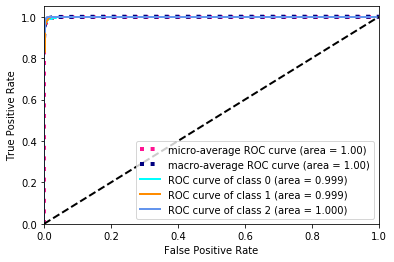

<Figure size 432x288 with 0 Axes>

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

import matplotlib.pyplot as plt
%matplotlib inline

pred = model.predict(X_test)

AUCfig = plt.figure()

# Binarize the multiclass labels
Y_bi = label_binarize(y, classes=['Austen', 'Dumas', 'Nabokov'])
n_classes = Y_bi.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.3f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC curve for each class')
plt.legend(loc="lower right")
plt.show()

plt.savefig('Arrows.pdf')
files.download('Arrows.pdf')

In [0]:
url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/outputs/all_scores.csv'
df = pd.read_csv(url).set_index('Unnamed: 0')
df

,old,new,old_masked,new_masked,label,donor_naturalness_score,style_naturalness_score,naturalness_delta,donor_authorship_score,style_authorship_score,authorship_delta
Unnamed: 0,,,,,,,,,,,
0,"stepped back a bit, as if admiring it, and hi...","stepped back a bit, to look at it, and his fem...","stepped back a bit, as if admiring it, and hi...","stepped back a bit, to look at it, and his fe...",N2A,0.990052,0.987915,0.002137,0.001385,0.002032,0.000647
1,Pal Palych! How’re they biting?” He looked up...,Pal Palych! How ’ re they biting? ” He looked ...,Pal Palych! How ’ re they biting? ” He looked...,Pal Palych! How ’ re they biting? ” He looked...,N2A,0.960177,0.992160,-0.031982,0.001012,0.007279,0.006267
2,but at least it revealed a small balcony one ...,but at least it revealed a small balcony above...,but at least it revealed a small balcony one ...,but at least it revealed a small balcony abov...,N2A,0.986264,0.994932,-0.008668,0.002908,0.772194,0.769286
3,"had not been placed together, told the waiter...","had not been placed together, told the waiter ...","had not been placed together, told the waiter...","had not been placed together, told the waiter...",N2A,0.959302,0.990870,-0.031567,0.001408,0.008916,0.007508
4,not a Portrait of Lolita: the differences bet...,not a Portrait of Lolita: the differences betw...,not a Portrait of <MASK>: the differences bet...,not a Portrait of <MASK>: the differences bet...,N2A,0.972211,0.994189,-0.021978,0.001623,0.112535,0.110911
5,"his right, the way Anglo-Saxons do in cartoon...","his right, the way Anglo-Saxons do in cartoons...","his right, the way Anglo-Saxons do in cartoon...","his right, the way Anglo-Saxons do in cartoon...",N2A,0.992910,0.992968,-0.000058,0.001225,0.004782,0.003556
6,"in a gigantic, joyous world. A tall pillar on...","in a gigantic, joyous world. A tall pillar on ...","in a gigantic, joyous world. A tall pillar on...","in a gigantic, joyous world. A tall pillar on...",N2A,0.975876,0.994505,-0.018629,0.001180,0.001295,0.000115
7,traversed by the black bend-let of a branch. ...,traversed by the black bend-let of a branch. A...,traversed by the black bend-let of a branch. ...,traversed by the black bend-let of a branch. ...,N2A,0.897903,0.897903,0.000000,0.035570,0.905704,0.870134
8,cross the frontier. One of the Cabinet Minist...,cross the frontier. One of the Cabinet Ministe...,cross the frontier. One of the Cabinet Minist...,cross the frontier. One of the Cabinet Minist...,N2A,0.967726,0.315845,0.651881,0.003134,0.004465,0.001332


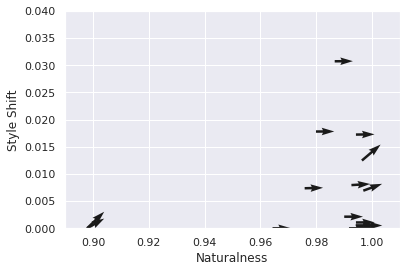

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

x = df['donor_naturalness_score'].values
y = df['style_naturalness_score'].values

u = df['naturalness_delta'].values
v = df['authorship_delta'].values

#plt.axis('equal')
plt.quiver(x,u,y,v)
plt.xlabel('Naturalness')
plt.ylabel('Style Shift')
plt.xlim(left=0.89, right=1.01)
plt.ylim(top=0.04, bottom=0)

plt.show()

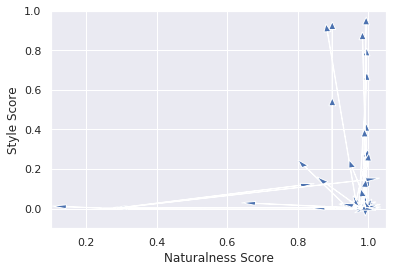

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline


x = df['donor_naturalness_score'].values
y = df['donor_authorship_score'].values

u = - df['naturalness_delta'].values
v = df['authorship_delta'].values

Arrows = plt.figure()
for i, j, k, l in zip(x, y, u, v): 
  plt.arrow(i, j, k, l, head_width=0.02, head_length=0.04)
plt.xlabel('Naturalness Score')
plt.ylabel('Style Score')
plt.xlim(left=0.1, right=1.05)
plt.ylim(top=1, bottom=-0.1)


from google.colab import files

plt.savefig('Arrows.pdf')
files.download('Arrows.pdf')

In [0]:
from google.colab import files
plt.savefig("abc.png")
files.download("abc.png") 

plt.savefig(('./gdrive/My Drive/DL/Style/arrows.pdf'))

<Figure size 432x288 with 0 Axes>